In [28]:
include("TDCM_full_transition.jl")
include("data_generation.jl")
using Distributions

In [29]:
N, J, K, O, L, S = 5000, 24, 3, 3, 8, 50
num_features_gamma = 3
Q = [0 0 0; 0 0 1; 0 1 0; 1 0 0; 0 1 1; 1 0 1; 1 1 0; 1 1 1;
     0 0 0; 0 0 1; 0 1 0; 1 0 0; 0 1 1; 1 0 1; 1 1 0; 1 1 1;
     0 0 0; 0 0 1; 0 1 0; 1 0 0; 0 1 1; 1 0 1; 1 1 0; 1 1 1]

X = Vector{Vector{Matrix{Float64}}}(undef, K)
for k in 1:K
     X[k] = Vector{Matrix{Float64}}(undef, O)
     X[k][1] = ones(N, 1)
     for t in 2:O
          X[k][t] = Matrix{Float64}(undef, N, 3)
          X[k][t][:,1] = ones(N)
          X[k][t][:,2] = rand(Normal(0, 1), N)
          X[k][t][:,3] = rand(Bernoulli(0.5), N)
     end
end
U = Vector{Vector{Matrix{Float64}}}(undef, K)
for k in 1:K
     U[k] = Vector{Matrix{Float64}}(undef, O)
     for t in 1:O
          U[k][t] = Matrix{Float64}(undef, S, 3)
          U[k][t][:,1] = ones(S)
          U[k][t][:,2] = rand(Bernoulli(0.5), S)
          U[k][t][:,3] = rand(Bernoulli(0.5), S)
     end
end

In [30]:
data = data_generation(Q, X, U, Int(O), Int(K), Int(S), Int(N/S), beta_interact=true);

In [31]:
obs = TDCMObs(data.Y, data.Q, data.U, data.X, data.group);

In [32]:
N, O, J, K, L, S = size(obs.Y, 1), size(obs.Y, 2), size(obs.Y, 3),  size(obs.Q, 2), size(obs.D[1], 1), size(obs.U[1][1], 1)

mu_beta_prior = Vector{Vector{Float64}}(undef, J)
L_beta_prior = Vector{Matrix{Float64}}(undef, J)
for j in 1:J
    num_features = size(obs.D[j], 2)
    mu_beta_prior[j] = zeros(num_features)
    L_beta_prior[j] = Matrix(1.0I, num_features, num_features)
end

mu_omega_prior = Vector{Vector{Vector{Vector{Vector{Float64}}}}}(undef, K)
L_omega_prior = Vector{Vector{Vector{Vector{Matrix{Float64}}}}}(undef, K)
a_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)
b_tau_prior = Vector{Vector{Vector{Vector{Float64}}}}(undef, K)

for k in 1:K
    mu_omega_prior[k] = Vector{Vector{Vector{Vector{Float64}}}}(undef, O)
    L_omega_prior[k] = Vector{Vector{Vector{Matrix{Float64}}}}(undef, O)
    a_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    b_tau_prior[k] = Vector{Vector{Vector{Float64}}}(undef, O)
    for t in 1:O
        num_features_gamma = size(obs.X[k][t], 2)
        num_features_omega = size(obs.U[k][t], 2)
        if t == 1
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 1)
            mu_omega_prior[k][t][1] = Vector{Vector{Float64}}(undef, 1)
            mu_omega_prior[k][t][1][1] = zeros(num_features_omega)

            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 1)
            L_omega_prior[k][t][1] = Vector{Matrix{Float64}}(undef, 1)
            L_omega_prior[k][t][1][1] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)

            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            a_tau_prior[k][t][1] = [.01]

            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 1)
            b_tau_prior[k][t][1] = [.01]
        else
            mu_omega_prior[k][t] = Vector{Vector{Vector{Float64}}}(undef, 2^(t-1))
            L_omega_prior[k][t] = Vector{Vector{Matrix{Float64}}}(undef, 2^(t-1))
            a_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2^(t-1))
            b_tau_prior[k][t] = Vector{Vector{Float64}}(undef, 2^(t-1))
            for z in 1:(2^(t-1))
                mu_omega_prior[k][t][z] = Vector{Vector{Float64}}(undef, num_features_gamma)
                L_omega_prior[k][t][z] = Vector{Matrix{Float64}}(undef, num_features_gamma)
                a_tau_prior[k][t][z] = ones(num_features_gamma) .* .01
                b_tau_prior[k][t][z] = ones(num_features_gamma) .* .01
                for m in 1:num_features_gamma
                    mu_omega_prior[k][t][z][m] = zeros(num_features_omega)
                    L_omega_prior[k][t][z][m] = Matrix{Float64}(1.0I, num_features_omega, num_features_omega)
                end
            end
        end
    end
end

In [33]:
M = 10
model = TDCModel(obs, mu_beta_prior, L_beta_prior, mu_omega_prior, L_omega_prior, a_tau_prior, b_tau_prior, M, enable_parallel=true)
optim = ADAMparams(model);

TDCModel constructed for computation on 12 threads


In [34]:
#Initialize betas in the correct direction
for j in 1:J
    model.mu_beta_star[j] = ones(length(model.mu_beta_star[j]))
    model.mu_beta_star[j][1] = -1
end

# Sample Z values
for i in 1:N
    for t in 1:O
        sample_Z(model, i, t)
    end
end

# Sample beta
sample_β(model)

# Sample gammas
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                sample_γ(model, s, t, k, 1)
            end
        else
            for z in 1:(2^(t - 1))
                for s in 1:S
                    sample_γ(model, s, t, k, z)
                end
            end
        end
    end
end

# Sample omega and tau values
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                sample_ω(model, k, t, 1, feature)
                sample_τ(model, k, t, 1, feature)
            end
        else
            for z in 1:(2^(t - 1))
                for feature in 1:num_features
                    sample_ω(model, k, t, z, feature)
                    sample_τ(model, k, t, z, feature)
                end
            end
        end
    end
end

In [45]:
for iter in 1:300
    update_categorical_variational_distribution(model, 1, step=.01, maxiter=5, verbose=false)
    update_categorical_variational_distribution(model, 2, step=.01, maxiter=5, verbose=false)
    update_normal_variational_distribution(model, init_step = .01, maxiter = 5, clip = 50.0, verbose = false, ADAMparams=optim)
    update_normal_variational_distribution2(model, init_step = .01, maxiter = 10, clip = 50.0, verbose = false, ADAMparams=optim)
    update_normal_variational_distribution3(model, init_step = .01, maxiter = 10, clip = 50.0, verbose = false, ADAMparams=optim)
    update_inverse_gamma_distribution(model, step = .01, maxiter = 5, verbose = false, ADAMparams=optim)
end

In [52]:
skill_profiles = Dict(1=>[0, 0, 0], 
                 2=>[0, 0, 1],
                 3=>[0, 1, 0],
                 4=>[0, 1, 1],
                 5=>[1, 0, 0],
                 6=>[1, 0, 1],
                 7=>[1, 1, 0],
                 8=>[1, 1, 1])

skill_numbers = Dict([0, 0, 0]=>1, 
                 [0, 0, 1]=>2,
                 [0, 1, 0]=>3,
                 [0, 1, 1]=>4,
                 [1, 0, 0]=>5,
                 [1, 0, 1]=>6,
                 [1, 1, 0]=>7,
                 [1, 1, 1]=>8)


preds = []
accuracy = 0
attribute_accs = zeros(L)
group_accs = zeros(S)

attribute_counts = zeros(L)
group_counts = zeros(S)

for i in 1:5000
    pred = skill_profiles[argmax(model.pi_star[i][2])]
    actual = skill_profiles[argmax(data.pi_star[i][2])]
    group_i = obs.group[i]
    profile_i = skill_numbers[actual]
    push!(preds, pred)
    correct = all(pred .== actual)
    accuracy += correct
    attribute_accs[profile_i] += correct
    group_accs[group_i] += correct
    attribute_counts[profile_i] += 1
    group_counts[group_i] += 1
end

accuracy = accuracy/N
attribute_accs .= attribute_accs ./ attribute_counts
group_accs .= group_accs ./ group_counts
;

In [53]:
accuracy

0.781

In [54]:
attribute_accs

8-element Vector{Float64}:
 0.9122807017543859
 0.5991792065663475
 0.6428571428571429
 0.4528985507246377
 0.7572815533980582
 0.8398972602739726
 0.34394904458598724
 0.9815303430079155

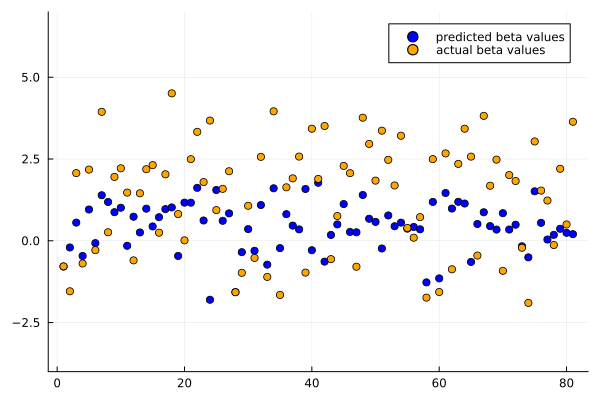

In [55]:
pred_beta_values = []
actual_beta_values = []
for j in 1:J
    for val in model.mu_beta_star[j]
        push!(pred_beta_values, val)
    end
    for val in data.mu_beta_star[j]
        push!(actual_beta_values, val)
    end
end

using Plots

x = 1:length(pred_beta_values)
plot(x, pred_beta_values, seriestype=:scatter, label = "predicted beta values", mc=:blue)
plot!(x, actual_beta_values, seriestype=:scatter, label = "actual beta values", mc=:orange)
#plot!(x, pred_beta_values, label = "", lc=:blue)
#plot!(x, actual_beta_values, label = "", lc=:orange)
ylims!(-4, 7)

In [58]:
model.mu_beta_star[2]

2-element Vector{Float64}:
 -0.20487674520882782
  0.5551976244312296

In [59]:
data.mu_beta_star[2]

2-element Vector{Float64}:
 -1.5446050077617444
  2.0688110835976428

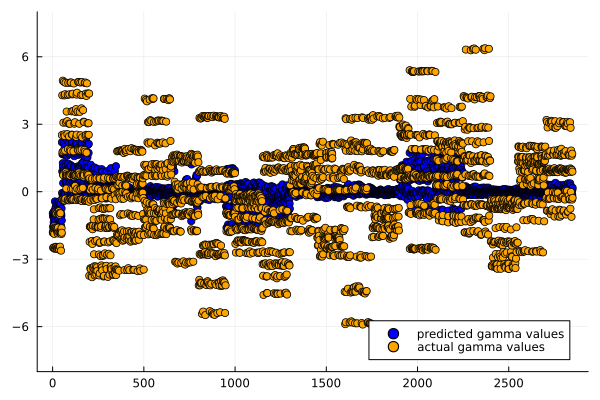

In [50]:
pred_gamma_values = []
actual_gamma_values = []
for k in 1:K
    for t in 1:O
        if t == 1
            for s in 1:S
                push!(pred_gamma_values, model.mu_gamma_star[k][t][1][s][1])
                push!(actual_gamma_values, data.mu_gamma_star[k][t][1][s][1])
            end
        else
            num_features = size(obs.X[k][t], 2)
            for z in 1:(2^(t-1))
                for s in 1:S
                    for feature in 1:num_features
                        push!(pred_gamma_values, model.mu_gamma_star[k][t][z][s][feature])
                        push!(actual_gamma_values, data.mu_gamma_star[k][t][z][s][feature])
                    end
                end
            end
        end
    end
end

x = 1:length(pred_gamma_values)
plot(x, pred_gamma_values, seriestype=:scatter, label = "predicted gamma values", mc=:blue)
plot!(x, actual_gamma_values, seriestype=:scatter, label = "actual gamma values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)

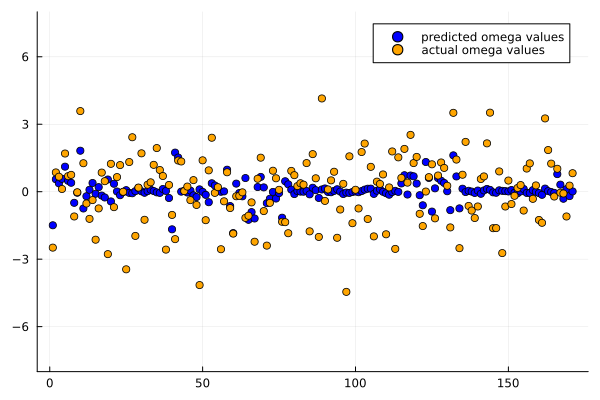

In [51]:
pred_omega_values = []
actual_omega_values = []
for k in 1:K
    for t in 1:O
        num_features = length(model.gamma_sample[k][t][1][1][1])
        if t == 1
            for feature in 1:num_features
                pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][1][feature])
                actual_omega_values = vcat(actual_omega_values, data.mu_omega_star[k][t][1][feature])
            end
        else
            for z in 1:(2^(t-1))
                for feature in 1:num_features
                    pred_omega_values = vcat(pred_omega_values, model.mu_omega_star[k][t][z][feature])
                    actual_omega_values = vcat(actual_omega_values, data.mu_omega_star[k][t][z][feature])
                end
            end
        end
    end
end

x = 1:length(pred_omega_values)
plot(x, pred_omega_values, seriestype=:scatter, label = "predicted omega values", mc=:blue)
plot!(x, actual_omega_values, seriestype=:scatter, label = "actual omega values", mc=:orange)
# plot!(x, pred_gamma_values, label = "", lc=:blue)
# plot!(x, actual_gamma_values, label = "", lc=:orange)
ylims!(-8, 8)